In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from cf_matrix import make_confusion_matrix as cm


In [33]:
def build_model(model, X, y, all_models, random_state=123, decision_function=True):
    '''
    Input - model: choice of statistical model
            X: features
            y: target
            random_state: default = 123, used for reproducibility
            decision_function: set to false for models with no decision_function method
            
    Output - printed acc, prec, rec, f1, auc scores
             model_dict: dictionary containing model results
    '''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state,
                                           test_size=0.2)
    model_dict = {}
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    if decision_function == True:
        y_score = model.decision_function(X_test)
    else:
        y_score = model.predict_proba(X_test)[:, 1]
        
    fpr, tpr, thresh = roc_curve(y_test, y_score)
    
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_ = auc(fpr,tpr)
    params = model.get_params()
    cfm = confusion_matrix(y_test, y_pred)
    
    model_dict['model'] = model
    model_dict['y_pred'] = y_pred
    model_dict['y_score'] = y_score
    model_dict['fpr'] = fpr
    model_dict['tpr'] = tpr
    model_dict['thresh'] = thresh
    model_dict['accuracy'] = acc
    model_dict['precision'] = pre
    model_dict['recall'] = rec
    model_dict['f1'] = f1
    model_dict['auc'] = auc_
    model_dict['params'] = params
    model_dict['cfm'] = cfm
    
    print(f'Accuracy: {round(acc, 3)}')
    print(f'Precision: {round(pre, 3)}')
    print(f'Recall: {round(rec, 3)}')
    print(f'F1 Score: {round(f1, 3)}')
    print(f'AUC: {round(auc_, 3)}')
    all_models.append(model_dict)
    
    return model_dict

In [3]:
# import data
train = pd.read_csv('../data/cs-training.csv', index_col=0).reset_index(drop=True)
X_train = train.drop('SeriousDlqin2yrs', axis=1)
y_train = train['SeriousDlqin2yrs']

# test = pd.read_csv('../data/cs-test.csv',  index_col=0).reset_index(drop=True)
# X_test = test.drop('SeriousDlqin2yrs', axis=1)
# y_test = test['SeriousDlqin2yrs']
# determine baseline model w/ linear regression

In [4]:
# minmax scaler: scales to fixed range 0-1
    # sensitive to outliers
# standard scaler: scales to mean=0, std=1
    # if dataset has normal distribution
    # sensitive to outliers
# robust scaler: removes median, scales to IQR
    # handles outliers and skew

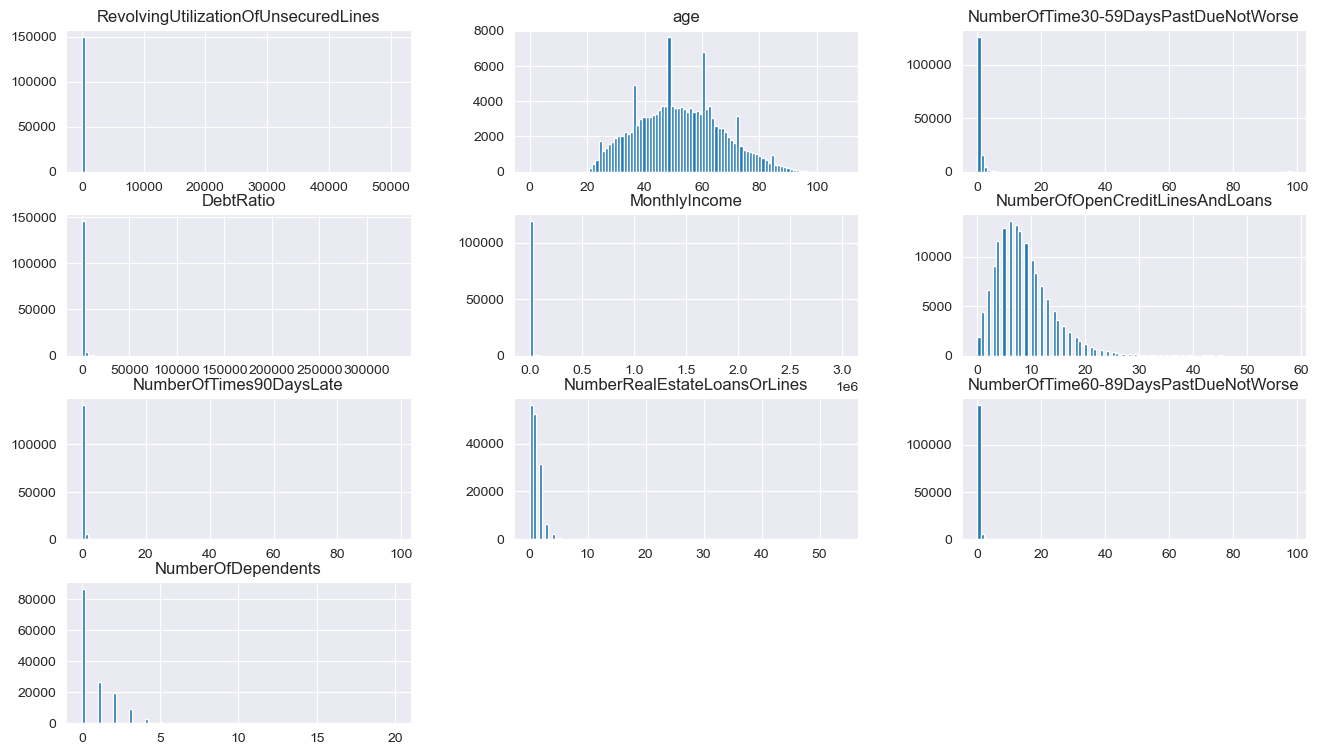

In [5]:
X_train.hist(figsize=(16,9), bins=100);

- remove outliers before scaling
    - IF not using robustscaler

## Preprocessing Notes from EDA Notebook
- Null values
    - MonthlyIncome:
        - large amount of nulls (~20%): cannot be dropped, will affect data by decreasing data points
        - heavy right skew: cannot be mean or median imputed, for simple solutions use mode imputation
    - NumberOfDependents:
        - relatively low number of nulls: could be dropped, but avoid if possible
        - right skew, not many unique values: can be mode imputed for simple solutions
- Outliers
    - NumberOfTimes90DaysLate: remove values > 17
        - determined based off of value_counts() results, showing large gap between 17 - 96
        - will result in 269 rows removed (0.17% of values)
    - RevolvingUtilizationOfUnsecuredLines: remove values > 1.35
        - will result in 765 rows removed (0.51% of values)
    - DebtRatio: remove values > 3839
        - determined based off of 98% quantile
        - will result in 2999 rows removed (2% of values)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

In [7]:
outliers = (X_train['NumberOfTimes90DaysLate'] <= 17) & (X_train['DebtRatio'] <=3839) & (X_train['RevolvingUtilizationOfUnsecuredLines'] <= 1.35)
X_train = X_train.loc[outliers]

In [8]:
y_train = y_train.loc[X_train.index]

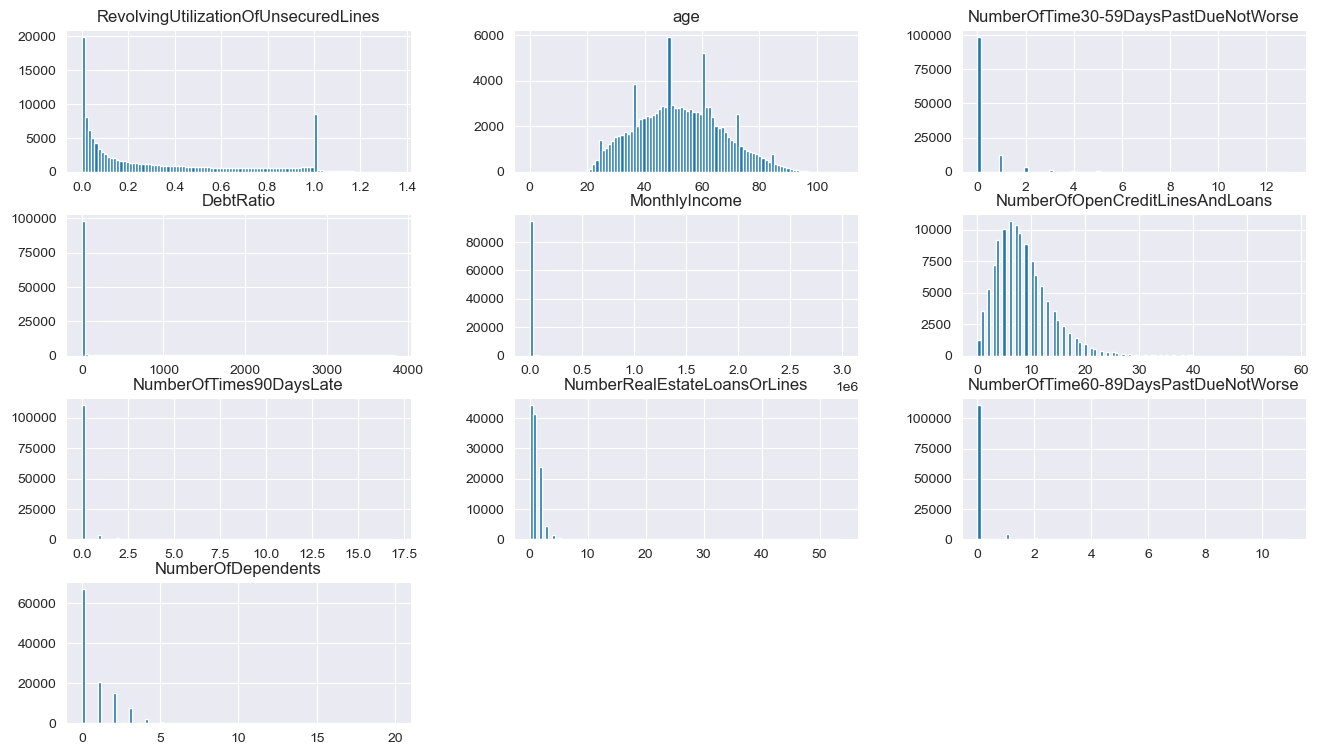

In [9]:
X_train.hist(figsize=(16,9), bins=100);

In [10]:
# mode imputation using simpleimputer
imp_mode = SimpleImputer(strategy='most_frequent')
imputed = imp_mode.fit_transform(X_train)
columns = X_train.columns
X_train = pd.DataFrame(imputed, columns=columns)

# to ensure X_train and y_train have identical indices
y_train = y_train.reset_index(drop=True)

- Mode imputation was chosen due to its simplicity.
- Median avoided since columns w/ missing data (MonthlyIncome, NumberofDependents) were not normally distributed, had heavy right skew 
- Improvements: MICE (multivariate imputation by chained equations)

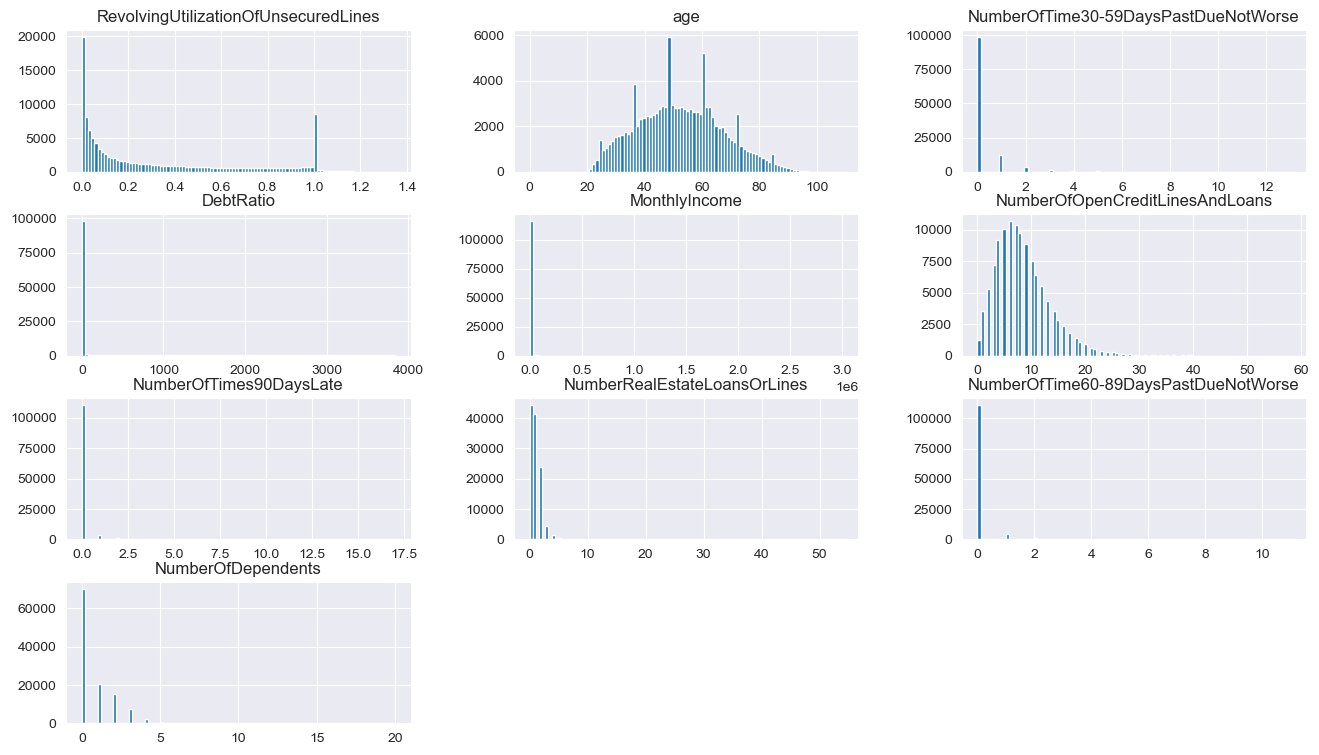

In [11]:
X_train.hist(figsize=(16,9), bins=100);

## Determining Feature Importance

- using random forest classifier
    - does not require features to be scaled, so can be used quickly without additional preprocessing
    - could also have been done before removing outliers

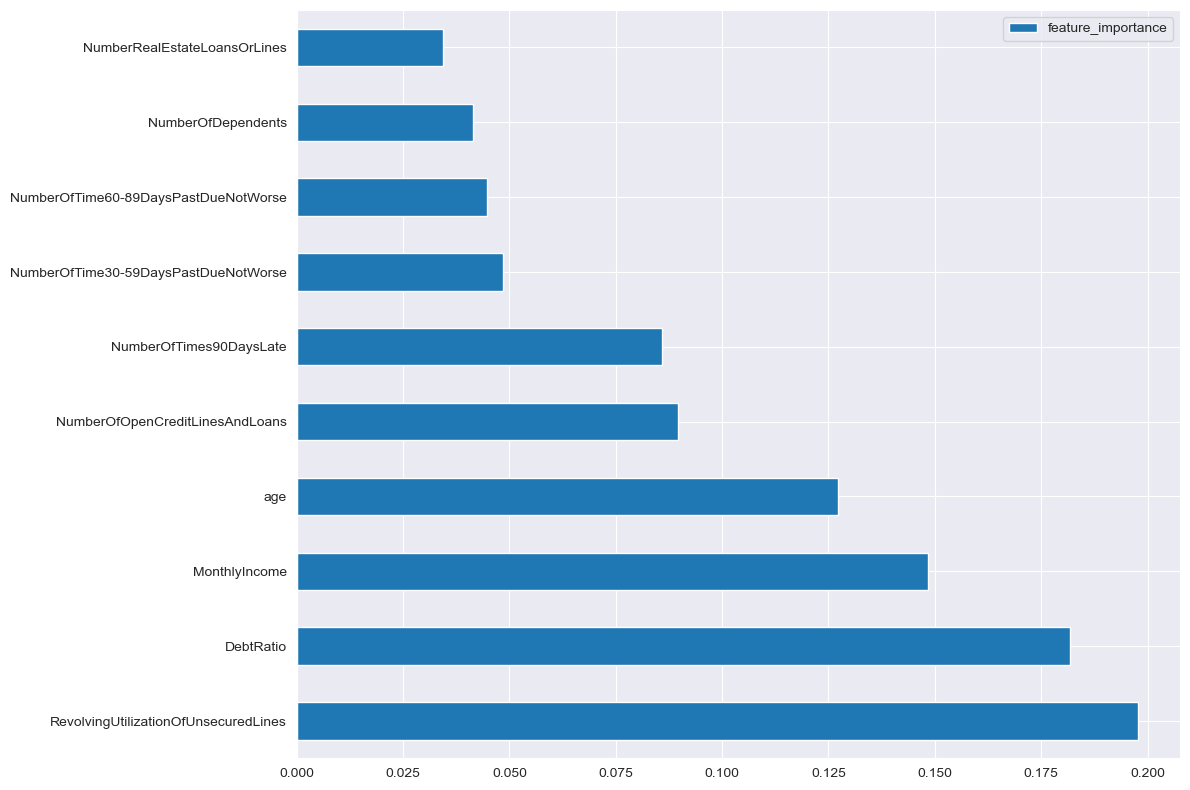

In [12]:
from sklearn.ensemble import RandomForestClassifier

# random forest classifier to determine feature importance
feature_names = X_train.columns
forest = RandomForestClassifier(random_state=123)
forest.fit(X_train, y_train)

# visualize feature importances
importances = forest.feature_importances_
forest_importances = pd.DataFrame(importances, index=feature_names, 
                                  columns=['feature_importance']
                                 ).sort_values('feature_importance', ascending=False)

fig, ax = plt.subplots(figsize=(12,8))
forest_importances.plot.barh(ax=ax)

fig.tight_layout()

Initial results shows 4 features w/ the highest feature importance to be:
1. RevolvingUtilizationOfUnsecuredLines
2. DebtRatio
3. MonthlyIncome
4. age

However, these 4 features also have the greatest number of unique values, which could be due to the high cardinality bias (gain in impurity reduction is inflated due to large number of unique values, model splits on unique value of feature more often). 

In [13]:
for col in X_train.columns:
    print(col)
    print(X_train[col].nunique())

RevolvingUtilizationOfUnsecuredLines
98362
age
86
NumberOfTime30-59DaysPastDueNotWorse
13
DebtRatio
90984
MonthlyIncome
12617
NumberOfOpenCreditLinesAndLoans
56
NumberOfTimes90DaysLate
17
NumberRealEstateLoansOrLines
28
NumberOfTime60-89DaysPastDueNotWorse
11
NumberOfDependents
13


In [19]:
# impute missing values in X_val w/ mode = 0
X_val = X_val.fillna(0)

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    forest, X_val, y_val, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)


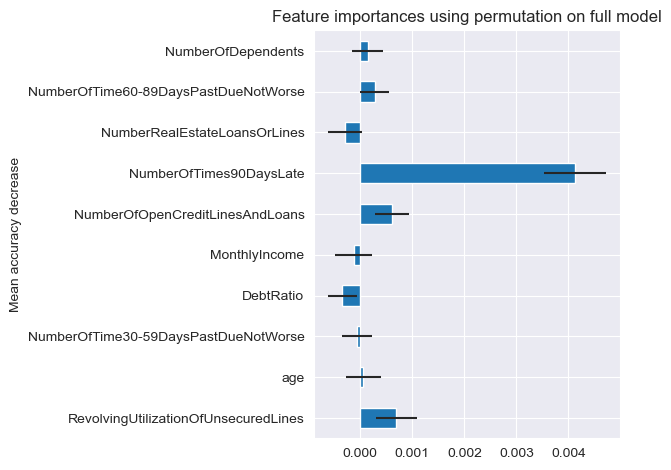

In [23]:
fig, ax = plt.subplots()
forest_importances.plot.barh(xerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Using permutation importance to determine feature importance generates a separate set of "important" features:
1. NumberOfTimes90DaysLate
2. __RevolvingUtilizationOfUnsecuredLines__ <-- same as mean decrease in impurity (MDI) method above
3. NumberOfOpenCreditLinesAndLoans
4. NumberOfTime60-89DaysPastDueNotWorse  <-- to be removed due to high correlation with feature 1


Determining which set of "important" features to use can be done using multiple methods:
1. Continue with BOTH sets of "important" features and establish a pipeline of scaling/fitting/modeling/analyzing results for both sets of features
2. Use domain knowledge to determine which set of features seems to be more plausible.

As my current knowledge of the credit risk domain is inadequate, I will proceed with using both sets of features and analyzing the results to decide on the "better" set (based on certain criteria).

In [28]:
mdi_feats = ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome','age']
perm_feats = ['NumberOfTimes90DaysLate','RevolvingUtilizationOfUnsecuredLines',
              'NumberOfOpenCreditLinesAndLoans']

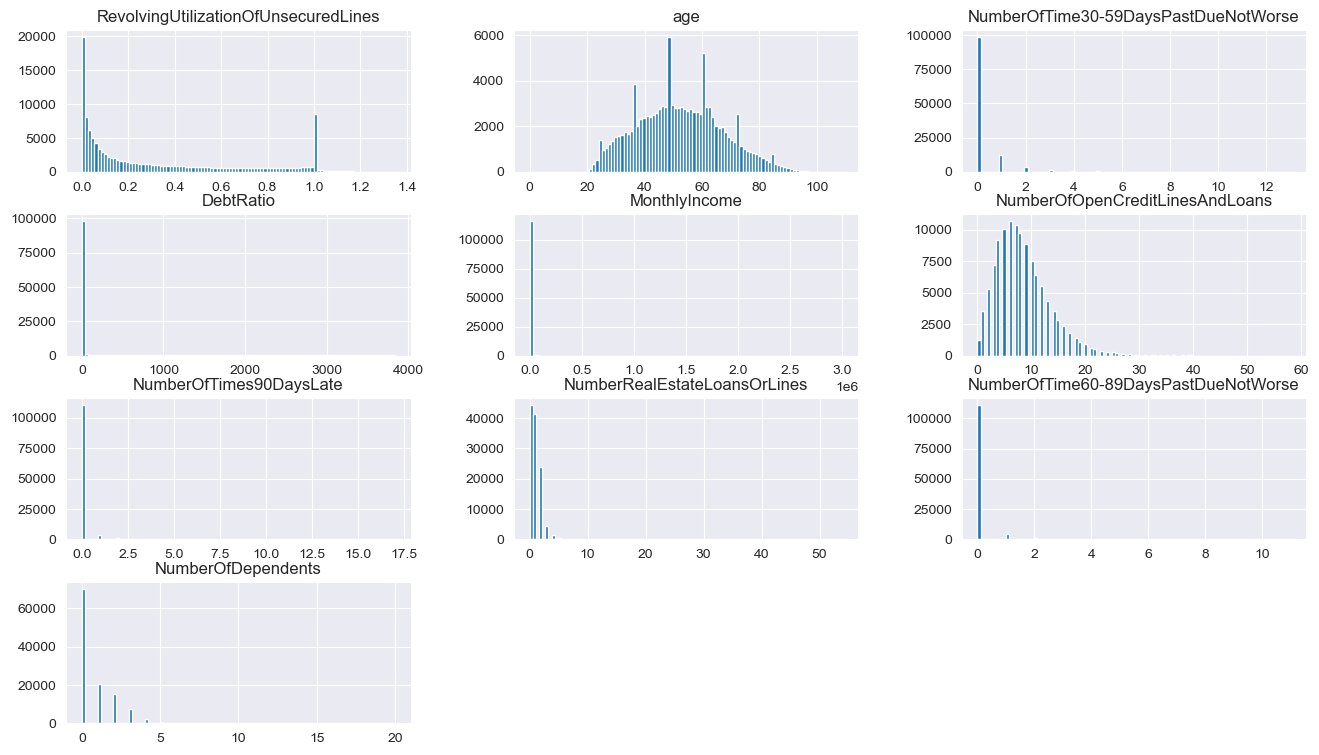

In [29]:
X_train.hist(figsize=(16,9), bins=100);

In [ ]:
def build_model(model, X, y, all_models, random_state=123, decision_function=True):
    '''
    Input - model: choice of statistical model
            X: features
            y: target
            random_state: default = 123, used for reproducibility
            decision_function: set to false for models with no decision_function method
            
    Output - printed acc, prec, rec, f1, auc scores
             model_dict: dictionary containing model results
    '''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state,
                                           test_size=0.2)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    if decision_function == True:
        y_score = model.decision_function(X_test)
    else:
        y_score = model.predict_proba(X_test)[:, 1]
        
    fpr, tpr, thresh = roc_curve(y_test, y_score)
    
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_ = auc(fpr,tpr)
    params = model.get_params()
    cfm = confusion_matrix(y_test, y_pred)
    
    model_dict = {}
    model_dict['model'] = model
    model_dict['y_pred'] = y_pred
    model_dict['y_score'] = y_score
    model_dict['fpr'] = fpr
    model_dict['tpr'] = tpr
    model_dict['thresh'] = thresh
    model_dict['accuracy'] = acc
    model_dict['precision'] = pre
    model_dict['recall'] = rec
    model_dict['f1'] = f1
    model_dict['auc'] = auc_
    model_dict['params'] = params
    model_dict['cfm'] = cfm
    
    print(f'Accuracy: {round(acc, 3)}')
    print(f'Precision: {round(pre, 3)}')
    print(f'Recall: {round(rec, 3)}')
    print(f'F1 Score: {round(f1, 3)}')
    print(f'AUC: {round(auc_, 3)}')
    all_models.append(model_dict)
    
    return model_dict

In [30]:
pipe_log = Pipeline([('scaler', RobustScaler()),
                     ('log', LogisticRegression(random_state=123))])

pipe_rf = RandomForestClassifier(n_estimators=500, random_state=123)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     28014
           1       0.55      0.19      0.28      1986

    accuracy                           0.94     30000
   macro avg       0.75      0.59      0.62     30000
weighted avg       0.92      0.94      0.92     30000



c:\Users\scott\miniconda3\envs\paidy\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
all_models = []
build_model(pipe_log,X_train, y_train, all_models)

Accuracy: 0.94
Precision: 0.673
Recall: 0.14
F1 Score: 0.232
AUC: 0.844


c:\Users\scott\miniconda3\envs\paidy\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'model': Pipeline(steps=[('scaler', RobustScaler()),
                 ('log', LogisticRegression(random_state=123))]),
 'y_pred': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'y_score': array([-3.39924282, -0.20070791, -4.35218649, ..., -4.3158442 ,
        -3.78244577, -1.41304514]),
 'fpr': array([0.00000000e+00, 4.57917392e-05, 4.57917392e-05, ...,
        9.99816833e-01, 9.99816833e-01, 1.00000000e+00]),
 'tpr': array([0.        , 0.        , 0.00131926, ..., 0.99934037, 1.        ,
        1.        ]),
 'thresh': array([         inf,   9.2392783 ,   6.83556773, ...,  -7.52462929,
         -9.45759145, -42.00297443]),
 'accuracy': 0.9397533613085552,
 'precision': 0.6730158730158731,
 'recall': 0.13984168865435356,
 'f1': 0.23156744948115784,
 'auc': 0.8436713973923116,
 'params': {'memory': None,
  'steps': [('scaler', RobustScaler()),
   ('log', LogisticRegression(random_state=123))],
  'verbose': False,
  'scaler': RobustScaler(),
  'log': LogisticRegression(random_state=123)

In [37]:
len(all_models)

1

In [38]:
all_models

[{'model': Pipeline(steps=[('scaler', RobustScaler()),
                  ('log', LogisticRegression(random_state=123))]),
  'y_pred': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
  'y_score': array([-3.39924282, -0.20070791, -4.35218649, ..., -4.3158442 ,
         -3.78244577, -1.41304514]),
  'fpr': array([0.00000000e+00, 4.57917392e-05, 4.57917392e-05, ...,
         9.99816833e-01, 9.99816833e-01, 1.00000000e+00]),
  'tpr': array([0.        , 0.        , 0.00131926, ..., 0.99934037, 1.        ,
         1.        ]),
  'thresh': array([         inf,   9.2392783 ,   6.83556773, ...,  -7.52462929,
          -9.45759145, -42.00297443]),
  'accuracy': 0.9397533613085552,
  'precision': 0.6730158730158731,
  'recall': 0.13984168865435356,
  'f1': 0.23156744948115784,
  'auc': 0.8436713973923116,
  'params': {'memory': None,
   'steps': [('scaler', RobustScaler()),
    ('log', LogisticRegression(random_state=123))],
   'verbose': False,
   'scaler': RobustScaler(),
   'log': LogisticRegres